Abstract:

The goal of this exploration is to train a model (Linear Regression or other) that can predict the species of a penguin from the palmer penguins dataset with 100% accuracy using 1 qualitative and 2 quantitative features. To begin this exploration, I filtered the data to allow for easier training to be completed. At the same time as filtering the data, I did some preliminary investigations into what combination of qualitative and quantitative features would be lead to predicting the correct penguin species. That investigation was done via grouping and aggregating the dataset and creating graphs comparing features. To actually confirm which combination of features would best predict penguin species I used the provided code from Professor Chodrow to loop through all possible feature combinations and check cross validation and training scores of each. I compiled that data into a dataframe and chose the set of features with the highest scores, that turned out to be island, culmen length, and culmen depth. That combination of features produced a Linear Regression model with 100% accuracy on the testing dataset.

Import training set and convert it to a pandas dataframe

In [42]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [43]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


Filter training data, converting the "Species" column into integer values to better predict on during training process. Also split up training data into a DataFrame of features and a list of the "Species" in integer form.

In [44]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


Feature exploration:

Figures produced comparing two quantitative features from the training data against one qualitative one. Following that is a grouping of the dataset specifically looking at mean Flipper Length of the different species compared to sex.

<Axes: xlabel='Flipper Length (mm)', ylabel='Body Mass (g)'>

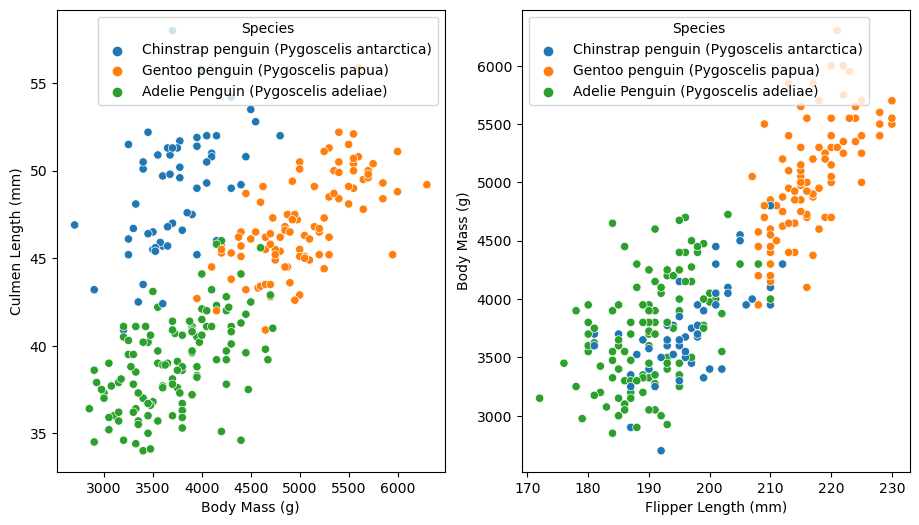

In [120]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (11, 6))
x1='Body Mass (g)'
y1='Culmen Length (mm)'
z1='Species'
sns.scatterplot(ax=ax[0], data=train[[z1, x1, y1]], x=x1, y=y1, hue=z1)

x2='Flipper Length (mm)'
y2='Body Mass (g)'
z2='Species'
sns.scatterplot(ax=ax[1], data=train[[z2, x2, y2]], x=x2, y=y2, hue=z2)

In [123]:
train.loc[train['Sex'] != '.'].groupby(['Species', 'Sex']).aggregate({'Flipper Length (mm)' : 'mean'})

Flipper Length (mm)
Species                                   Sex                        
Adelie Penguin (Pygoscelis adeliae)       FEMALE           187.924528
                                          MALE             192.327869
Chinstrap penguin (Pygoscelis antarctica) FEMALE           192.064516
                                          MALE             200.692308
Gentoo penguin (Pygoscelis papua)         FEMALE           212.836735
                                          MALE             221.204545

Main Training Loop:

The following code is the main training loop, going over all possible combinations of the chosen quantitative and qualitative features. Each qualitative feature is paired with two quantitative ones and then a linear regression model is trained on those. The cross validation an score of the model is calculated and appended to a list along with the feature combinations to keep track of which features score the best.

In [100]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=5000)

all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]
LR_scores = []
for qual in all_qual_cols:
    qual_cols = [col for col in X_train.columns if qual in col]
    for pair in combinations(all_quant_cols, 2):
        cols = list(pair) + qual_cols
        print(cols)
        LR.fit(X_train[cols], y_train)
        cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv = 5)
        score = LR.score(X_train[cols], y_train)
        LR_scores.append([cv_scores_LR.mean(), score] + cols)

['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']
['Culmen Length (mm)', 'Flipper Length (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']
['Culmen Length (mm)', 'Body Mass (g)', 'Clutch Completion_No', 'Clutch Completion_Yes']
['Culmen Depth (mm)', 'Flipper Length (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']
['Culmen Depth (mm)', 'Body Mass (g)', 'Clutch Completion_No', 'Clutch Completion_Yes']
['Flipper Length (mm)', 'Body Mass (g)', 'Clutch Completion_No', 'Clutch Completion_Yes']
['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE']
['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex_FEMALE', 'Sex_MALE']
['Culmen Length (mm)', 'Body Mass (g)', 'Sex_FEMALE', 'Sex_MALE']
['Culmen Depth (mm)', 'Flipper Length (mm)', 'Sex_FEMALE', 'Sex_MALE']
['Culmen Depth (mm)', 'Body Mass (g)', 'Sex_FEMALE', 'Sex_MALE']
['Flipper Length (mm)', 'Body Mass (g)', 'Sex_FEMALE', 'Sex_MALE']
['Culmen Length (mm)', 'Culmen Depth (mm

Convert the LR_scores list into a DataFrame for data analysis

In [101]:
LR_df = pd.DataFrame(LR_scores)


After looking at the top score the row with the best cross validation and training score were chosen, this value was hardcode, but could probably be chose by finding the max value in the first column. Once the features are selected from that process they are used to retrain a linear regression model.

In [102]:
max_cols = LR_df.iloc[12]
cols = max_cols[2:]
LR.fit(X_train[cols], y_train)

LogisticRegression(max_iter=5000)

Import testing data and prepare it then calculate a score on the data using LR model that was trained in the last step.

In [103]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
LR.score(X_test[cols], y_test)

1.0

The following code is copied from Professor Chodrow is is used to visual the results from model training.

In [104]:
from matplotlib import pyplot as plt
import numpy as np

from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

Plot regions and visualize model prediction success. Following that a confusion matrix was produced to further show model prediction rates.

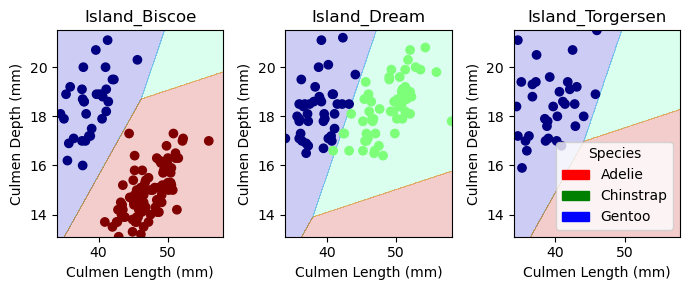

In [105]:
plot_regions(LR, X_train[cols], y_train)

In [106]:
from sklearn.metrics import confusion_matrix

y_test_pred = LR.predict(X_test[cols])
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

Looking at the above confusion matrix we are correctly predicting all of the categories we possibly can. The first column is predicted Biscoe islands, the second predicted Dream, and third predicted Torgersen and as we can see all the islands were correctly predicted.

Discussion:

Looking back at the results from this experimentation, we can see that when working with the palmer penguins dataset we can produced a linear regression model that predicts the species of a test set that hasn't been seen before with 100% accuracy when the model is trained using Island, Culmen Length, and Culmen Depth. However, I personally am very skeptical of a model that can predict with 100% accuracy, no amount of features will ever be a perfect calculator for predicting something and I hypothesize that if the palmer penguins dataset was larger and there were more outliers we wouldn't see such a high training score. That being said, it is cool to see how we can train a model to pattern recognize and we can be smart about what patterns we guide our model to recognize in order to best set up its predicting capabilities.